<a href="https://colab.research.google.com/github/kimnamgyo/kimnamgyo.github.io/blob/master/practice_classification_1(2019250004_%EA%B9%80%EB%82%A8%EA%B5%90)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

연습: _타이타닉 데이터 세트를 처리합니다. 시작하기에 좋은 장소는 [Kaggle](https://www.kaggle.com/c/titanic)입니다. 또는 https://homl.info/titanic.tgz 에서 데이터를 다운로드하여 2장의 하우징 데이터에 대해 했던 것처럼 이 tarball의 압축을 풀 수 있습니다. 그러면 두 개의 CSV 파일 _train.csv_와 _test.csv_가 제공됩니다. 이 파일은 'pandas.read_csv()lindo'를 사용하여 로드할 수 있습니다. 목표는 다른 열을 기반으로 "생존" 열을 예측할 수 있는 분류기를 훈련시키는 것입니다._

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

데이터가 이미 교육 세트와 테스트 세트로 분할되어 있습니다. 그러나 테스트 데이터에는 레이블이 *포함되지* 않습니다. 교육 데이터를 사용하여 최상의 모델을 교육한 다음 테스트 데이터에 대한 예측을 하고 Kaggle에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

교육 세트의 상위 몇 줄을 살펴보겠습니다:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


속성의 의미는 다음과 같습니다:
* **PassengerId**: 각 승객의 고유 식별자
* **Survived**: 그것이 목표입니다. 0은 승객이 살아남지 못했다는 것을 의미하고, 1은 승객이 살아남았다는 것을 의미합니다.
* **Pclass**: 승객 클래스.
* **Name**, **Sex**, **Age**: 자기설명
* **SibSp**: 타이타닉에 탑승한 승객의 형제자매와 배우자 수.
* **Parch**: 타이타닉에 탑승한 승객의 자녀와 부모 수.
* **Ticket**: 티켓 ID
* **Fare**: 지불된 가격(파운드)
* **Cabin**: 승객 객실 번호
* **Embarked**: 승객이 타이타닉에 탑승한 장소

목표는 승객의 나이, 성별, 승객 등급, 탑승 장소 등의 속성을 기반으로 승객의 생존 여부를 예측하는 것입니다.

'PassengerId' 열을 인덱스 열로 명시적으로 설정합니다

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

누락된 데이터의 양을 확인하려면 다음과 같이 하십시오

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

**Age**, **Cabin** 및 **Embarked** 특성은 때때로 null(891개 미만의 null)이며, 특히 **Cabin**(77%가 null)입니다. 우리는 지금은 **Cabin**을 무시하고 나머지에 집중할 것입니다. **Age** 특성의 null 값은 약 19%이므로 이 값으로 수행할 작업을 결정해야 합니다. null 값을 중위수 연령으로 대체하는 것이 합리적인 것 같습니다. 다른 열을 기준으로 나이를 예측하면 조금 더 현명해질 수 있습니다(예: 중위 연령은 1등 37세, 2등 29세, 3등 24세). 하지만 우리는 단순하게 유지하고 전체 중위 연령을 사용할 것입니다.

**Name** 및 **Ticket** 속성은 일부 값을 가질 수 있지만 모델이 사용할 수 있는 유용한 숫자로 변환하기가 다소 까다로울 수 있습니다. 그래서 지금은, 우리는 그들을 무시할 것입니다.

수치 속성을 살펴보겠습니다:

In [ ]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 단 38%만이 **Survived**되었습니다. 이는 40%에 충분히 가깝기 때문에 정확도는 모델을 평가하는 데 합리적인 측정 기준이 될 것입니다.
* 평균 **Fare**는 £32.20으로, 그렇게 비싸지는 않은 것 같습니다(그러나 그 당시에는 아마도 큰 돈이었을 것입니다).
* 평균 **Age**는 30세 미만이었습니다.

목표값이 실제로 0 또는 1인지 확인합니다:

In [ ]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Jagained 속성은 승객이 탑승한 위치를 알려줍니다. C=Cherbourg, Q=Queensstown, S=Southampton.

이제 수치 속성을 위한 파이프라인부터 시작하여 전처리 파이프라인을 구축해 보겠습니다:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

이제 범주형 특성을 위한 파이프라인을 구축할 수 있습니다:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [ ]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

마지막으로, 수치 및 범주형 파이프라인을 만들어 보겠습니다:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

이제 원시 데이터를 가져와서 원하는 모든 기계 학습 모델에 제공할 수 있는 수치 입력 기능을 출력하는 훌륭한 전처리 파이프라인이 있습니다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
y_train = train_data["Survived"]

이제 분류자를 교육할 준비가 되었습니다. "랜덤 포레스트 분류기"로 시작하겠습니다:

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

이 모델은 교육을 받은 모델입니다. 이를 사용하여 테스트 세트에 대한 예측을 해 보겠습니다:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

이제 이러한 예측(Kaggle이 제외한 형식)을 사용하여 CSV 파일을 구축한 다음 업로드하여 최상의 결과를 기대할 수 있습니다. 하지만 잠깐! 우리는 희망보다 더 잘 할 수 있습니다. 교차 검증을 사용하여 모델이 얼마나 우수한지 파악해 보는 것은 어떨까요?

In [ ]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

Kaggle에서 열리는 타이타닉 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)를 보면, 우리의 점수가 상위 2%에 있다는 것을 알 수 있습니다. 일부 카글러들은 100% 정확도에 도달했지만, 여러분은 [타이타닉의 희생자 목록](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾을 수 있기 때문에, 그들의 성능에 기계 학습이 거의 개입되지 않았을 가능성이 높습니다.

SVC를 사용해 보겠습니다:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

그러나 10개의 교차 검증 접기에서 평균 정확도를 확인하는 대신, 각 모델에 대한 10개의 모든 점수를 하위 및 상위 사분위수를 강조하는 상자 그림과 점수의 범위를 보여주는 "whiskers"와 함께 표시합니다(이 시각화를 제안한 Nevin Yilmaz 덕분). 'boxplot()' 함수는 특이치("플라이어"라고 함)를 감지하며  whiskers에는 포함되지 않습니다. 특히, 하위 사분위수가 $Q_1$이고 상위 사분위수가 $Q_3$이면, 사분위수 범위 $IQR = Q_3 - Q_1$(이것은 상자 높이)이며, $Q_1 - 1.5 \times IQR$보다 낮은 점수는 플라이어이며, $Q3 + 1.5 \times IQR$보다 큰 점수도 마찬가지입니다.

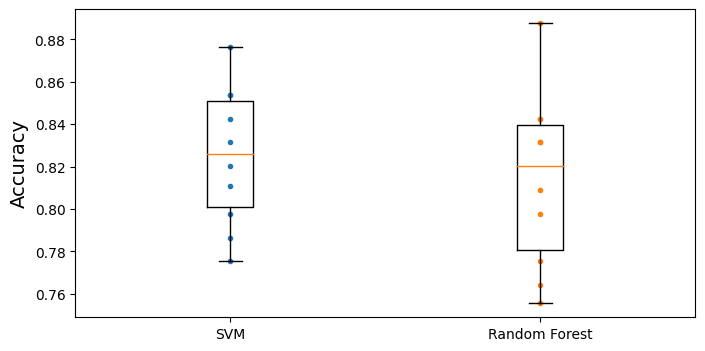

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

랜덤 포레스트 분류기는 10개의 접힌 부분 중 하나에서 매우 높은 점수를 받았지만 전체적으로 평균 점수가 낮고 확산도 커 SVM 분류기가 일반화될 가능성이 더 높은 것으로 보입니다.

이 결과를 더욱 개선하기 위해 다음을 수행할 수 있습니다:
* 교차 검증 및 그리드 검색을 사용하여 더 많은 모델을 비교하고 하이퍼 파라미터를 조정합니다,
* 다음과 같이 피쳐 엔지니어링을 더 수행합니다:
* 숫자 속성을 범주형 속성으로 변환해 보십시오. 예를 들어, 연령 그룹에 따라 생존율이 매우 다르므로(아래 참조) 연령 버킷 범주를 만들어 연령 대신 사용하는 것이 도움이 될 수 있습니다. 마찬가지로, 30%만 생존했기 때문에 혼자 여행하는 사람들을 위한 특별한 범주를 갖는 것이 유용할 수 있습니다(아래 참조).
* **SibSp** 및 **Parch**를 합으로 바꿉니다.
* **Survived** 특성과 잘 연관된 이름 부분을 식별합니다.
* **cabin** 열을 사용합니다. 예를 들어, 첫 번째 문자를 사용하여 범주형 속성으로 처리합니다.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### 4. 스팸 분류기

연습: _스팸 분류기 만들기(더 어려운 연습):_


* _[Apache SpamAssassin 공개 데이터 세트](https://homl.info/spamassassin) 에서 스팸과 햄의 예를 다운로드합니다._
* _데이터 세트의 압축을 풀고 데이터 형식을 숙지합니다._
* _데이터 세트를 교육 세트와 테스트 세트로 나눕니다._
* _데이터 준비 파이프라인을 작성하여 각 이메일을 기능 벡터로 변환합니다. 준비 파이프라인은 전자 메일을 가능한 각 단어의 존재 여부를 나타내는 (희소) 벡터로 변환해야 합니다. 예를 들어 모든 전자 메일에 "Hello", "how", "are", "you" 등 네 단어만 포함되어 있는 경우 "Hello Hello"는 벡터 [1, 0, 0, 1]("Hello"가 있음, "how"가 없음, "you"가 없음, "you"가 있음을 의미) 또는 각 단어의 발생 횟수를 세는 [3, 0, 0, 2]로 변환됩니다._

_전자 메일 헤더 제거, 각 전자 메일을 소문자로 변환, 구두점 제거, 모든 URL을 "URL"로 바꾸거나, 모든 숫자를 "NUMBER"로 바꾸거나, _Steaming_(즉, 단어 끝 부분을 잘라내기 위해 사용 가능한 Python 라이브러리가 있음)을 제어하기 위해 준비 파이프라인에 하이퍼 파라미터를 추가할 수 있습니다._

_마지막으로, 몇 개의 분류기를 사용해보고 높은 리콜과 높은 정밀도로 훌륭한 스팸 분류기를 만들 수 있는지 확인해보세요._

In [ ]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [ ]:
ham_dir, spam_dir = fetch_spam_data()

다음으로 모든 전자 메일을 로드합니다:

In [ ]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [ ]:
len(ham_filenames)

2500

In [ ]:
len(spam_filenames)

500

Python의 '이메일' 모듈을 사용하여 다음 이메일을 구문 분석할 수 있습니다(헤더, 인코딩 등을 처리함):

In [ ]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

ham과 스팸 메일의 예를 보고 데이터가 어떻게 생겼는지 알아봅시다.

In [ ]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [ ]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


일부 전자 메일은 실제로 이미지와 첨부 파일(자체 첨부 파일이 있을 수 있음)이 있는 다중 부분입니다. 다음과 같은 다양한 유형의 구조를 살펴보겠습니다:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [ ]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

스팸 메일은 꽤 많은 HTML을 가지고 있는 반면, 햄 메일은 더 일반적인 텍스트인 것 같습니다. 게다가 꽤 많은 수의 햄 메일은 PGP를 사용하여 서명되고 스팸은 없습니다. 간단히 말해서, 이메일 구조는 가지기에 유용한 정보인 것 같습니다.

이제 전자 메일 헤더를 살펴보겠습니다:

In [ ]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

여기에는 보낸 사람의 이메일 주소(12a1mailbot1@web.de 가 수상해 보이는 등)와 같은 유용한 정보가 많이 포함되어 있을 것입니다. 하지만 여기서는 '제목' 헤더에만 집중하겠습니다:

In [ ]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

자, 이제 전처리 함수 작성을 시작하겠습니다. 먼저 HTML을 일반 텍스트로 변환하는 기능이 필요합니다. 이를 위한 가장 좋은 방법은 틀림없이 훌륭한 [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) 라이브러리를 사용하는 것이겠지만, 저는 이 프로젝트에 또 다른 의존성을 추가하는 것을 피하고 싶으므로, 정규 표현을 사용하여 빠르고 더러운 해결책을 해킹해 봅시다([honhoily radience]가 모든 enlio를 파괴하는 위험을 무릅쓰고)https://stackoverflow.com/a/1732454/38626)) . 다음 함수는 먼저 "<head>" 섹션을 삭제한 다음 모든 "<a>" 태그를 하이퍼링크로 변환한 다음 HTML 태그를 모두 제거하고 일반 텍스트만 남깁니다. 또한 가독성을 위해 여러 줄의 줄을 하나의 줄로 바꾸고 마지막으로 HTML 엔티티(예: "&gt;" 또는 "&nbsp;")를 해제합니다:

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

효과가 있는지 확인해 보겠습니다. HTML 스팸입니다:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

다음은 일반 텍스트입니다:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

이제 이메일을 입력으로 받아들이고 이메일의 내용을 일반 텍스트로 반환하는 함수를 작성해 보겠습니다:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


약간의 단서를 넣읍시다! Natural Language Toolkit([NLTK](http://www.nltk.org/)) :

In [ ]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


우리는 또한 URL을 "URL"이라는 단어로 대체하는 방법이 필요할 것입니다. 이를 위해 하드코어 [정규식](https://mathiasbynens.be/demo/url-regex) )를 사용할 수 있지만 [urlextract](https://github.com/lipoja/URLExtract) 라이브러리:

In [ ]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# if running this notebook on Colab or Kaggle, we just pip install urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

**참고:** Jupyter 노트북에서는 항상 "!pip"이 잘못된 환경에 라이브러리를 설치할 수 있으므로 "!pip" 대신 "%pip"을 사용하십시오. 반면 "%pip"은 라이브러리가 현재 실행 중인 환경에 설치되어 있는지 확인합니다.

In [ ]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


우리는 이메일을 워드 카운터로 변환하는 데 사용할 이 모든 것을 변압기에 넣을 준비가 되어 있습니다. 단어 경계에 공백을 사용하는 Python의 'split()' 메서드를 사용하여 문장을 단어로 분할합니다. 이것은 많은 필기 언어에 적용되지만 전부는 아닙니다. 예를 들어, 중국어와 일본어 대본은 일반적으로 단어 사이에 공백을 사용하지 않고, 베트남어는 음절 사이에도 공백을 사용하는 경우가 많습니다. 이 연습에서는 데이터 세트가 (대부분이) 영어로 되어 있기 때문에 괜찮습니다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

몇 가지 이메일을 통해 이 변환환기를 사용해 보겠습니다:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

이제 단어 카운트를 벡터로 변환해야 합니다. 이를 위해 'fit()' 메서드가 어휘(가장 일반적인 단어의 정렬된 목록)를 구축하고 'transform()' 메서드가 어휘를 사용하여 단어 수를 벡터로 변환하는 또 다른 변압기를 구축합니다. 출력은 희소 행렬입니다.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [ ]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

이 행렬은 무엇을 의미합니까? 두 번째 줄의 첫 번째 열에 있는 99개의 단어는 두 번째 이메일에 어휘의 일부가 아닌 99개의 단어가 포함되어 있다는 것을 의미합니다. 옆에 있는 11은 이 이메일에 어휘의 첫 번째 단어가 11번 있다는 것을 의미합니다. 그 옆에 있는 9는 두 번째 단어가 9번이나 있다는 것을 의미합니다. 여러분은 우리가 어떤 단어를 말하고 있는지 알기 위해 어휘를 볼 수 있습니다. 첫 번째 단어는 "the", 두 번째 단어는 "of" 등입니다.

In [ ]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

이제 첫 번째 스팸 분류기를 교육할 준비가 되었습니다! 전체 데이터셋을 혁신해 보겠습니다:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

98.5% 이상으로, 처음 시도하기에는 나쁘지 않습니다! :) 그러나 우리는 "쉬운" 데이터 세트를 사용하고 있다는 것을 기억하십시오. 더 어려운 데이터셋을 사용해 볼 수 있습니다. 결과는 그리 놀랍지 않을 것입니다. 여러 모델을 시도하고, 가장 적합한 모델을 선택한 후 교차 검증을 사용하여 미세 조정해야 합니다.

하지만 그림을 이해할 수 있으므로 이제 그만 두고 테스트 세트에 표시된 정밀도/호출 정보만 출력합니다:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%
